# Analysis of polarization in retweets and replies

In [57]:
import os
import sys
sys.path.append('../../src')
PATH = '/home/piotr/projects/twitter'
START = '2020_02_23'
END = '2020_07_15'
PATH_DATA = os.path.join(PATH, 'data/clean')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
from twitter_models.polarization import ModelPolarization
from twitter_tools.utils import read_window, read_files
from tqdm.notebook import tqdm
from functools import partial
import ast
import gc
import pandarallel

In [6]:
PATH_STOPWORDS = '/home/piotr/nlp/polish.stopwords.txt'
stopwords = []
with open(PATH_STOPWORDS, 'r') as f:
    for line in f:
        word = line.strip('\n')
        if word != 'nie':
            stopwords.append(word)
stopwords.append('mieć')
PATH_DROP = os.path.join(PATH, 'results/cleaning/DROP_IDS.json')
START = '2020_02_23'
END = '2020_07_15'
dtypes = json.load(open(os.path.join(PATH, 'results/cleaning/dtypes.json'), 'r'))
PATH_DICT = os.path.join(PATH, 'results/topics/mallet/topic_dict.json')
topic_dict = json.load(open(PATH_DICT, 'r'))
PATH_TOPICS = os.path.join(PATH, 'results/topics/mallet/topic_map.json')
topic_map = json.load(open(PATH_TOPICS, 'r'))
PATH_TOKENS = os.path.join(PATH, 'results/topics/mallet/topic_tokens.json')
topic_tokens = json.load(open(PATH_TOKENS, 'r'))

In [7]:
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_tweets.json')
drop_tweets = json.load(open(PATH_DROP, 'r'))
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_users.json')
drop_users = json.load(open(PATH_DROP, 'r'))

#filter function:
def filter_fun(df:pd.DataFrame, drop_users:list, drop_tweets:list, drop_duplicates = False, keep_cols = None, **kwargs):
    df = df[np.logical_not(df['user-id_str'].isin(drop_users))] #drop IDs that are to be excluded
    df = df[np.logical_not(df['id_str'].isin(drop_tweets))]
    if drop_duplicates:
        df.drop_duplicates(inplace = True, **kwargs)
    if keep_cols is not None:
        df = df[keep_cols]
    return df
ff = partial(filter_fun, drop_users = drop_users, drop_tweets = drop_tweets, 
             subset = ['lemmatized'], keep_cols = ['full_text', 'day','lemmatized','id_str','user-id_str', 'source', 'lemmas'])

def weighted_average(group, weight_name):
    weights = group['n']
    score = group['score']   
    return np.average(score,weights=weights)

### Get Tweet-level polarization for each of the Tweets:

In [ ]:
PATH_SCORES = os.path.join(PATH, 'results/polarization/tweet_polarization.json')
PATH_DATA = os.path.join(PATH, 'data/clean')
START = '2020_02_23'
END = '2020_07_15'

if os.path.isfile(PATH_SCORES):
    tweets_polarization = json.load(open(PATH_SCORES, 'r'))
else:
    ff = partial(filter_fun, drop_users=drop_users, drop_tweets=drop_tweets)
    tweets_polarization = dict()
    for df in tqdm(read_window(PATH_DATA, n=7,  batch_size=1, 
                               day_from=START, day_to=END, dtype=dtypes, filter_fun=ff)):
        df.loc[:, 'ntokens'] = df['lemmas'].apply(lambda x: len(ast.literal_eval(x)))
        df = df.loc[df['ntokens'] >= df['ntokens'].median(), :]
        
        #keep only unique across party and text:
        orig = df.drop_duplicates(subset=['lemmatized','source'])
        
        #fit vectorizer on all vocabulary:
        model = ModelPolarization(parties=["gov", "opp"], limit=40, ngram_range=(1,2), log=20, stop_words=stopwords)
        model.prefit(orig["lemmatized"].astype(str).to_numpy())
        date_range = sorted(pd.to_datetime(df.day.unique()))
        mid_date = date_range[3].date().strftime('%Y-%m-%d')
        orig = orig[orig['day'] == mid_date]
        df = df[df['day'] == mid_date]
        
        #estimate:
        est = model.estimate(orig['source'], orig['user-id_str'], orig['lemmatized'], 
                         text_id = orig['id_str'], level ='speech', leave_out = True)
        orig['pol'] = orig['id_str'].apply(lambda x: est.get(x))
        #map the polarization scores on non-unique tweets:
        pol_dict = orig[['lemmatized','source','pol']].set_index(['lemmatized','source'])['pol'].to_dict()
        df['ind'] = tuple(zip(df['lemmatized'], df['source']))
        df['pol'] = df['ind'].apply(lambda x: pol_dict.get(x))
        df = df[['id_str','pol']].set_index('id_str')['pol'].to_dict()
        #save:
        tweets_polarization.update(df)
    json.dump(tweets_polarization, open(PATH_SCORES, 'w'))

In [2]:
def fit_pol(df, **kwargs):
        model = ModelPolarization(parties=["gov", "opp"], **kwargs)
        model.prefit(df["lemmatized"].astype(str).to_numpy())
        date_range = sorted(pd.to_datetime(df.day.unique()))
        mid_date = date_range[3].date().strftime('%Y-%m-%d')
        df = df[df['day'] == mid_date]
        est = model.estimate(df['source'], df['user-id_str'], df['lemmatized'], 
                       text_id = df['id_str'],level = 'speech',conf_int = None)
        del model
        gc.collect()
        return est

In [59]:
PATH_SCORES = os.path.join(PATH, 'results/polarization/tweet_polarization_bytopic.json')
PATH_DATA = os.path.join(PATH, 'data/clean')
START = '2020_02_23'
END = '2020_07_15'

pandarallel.pandarallel.initialize(nb_workers = 3)

if os.path.isfile(PATH_SCORES):
    tweets_polarization = json.load(open(PATH_SCORES, 'r'))
else:
    ff = partial(filter_fun, drop_users=drop_users, drop_tweets=drop_tweets)
    tweets_polarization = dict()
    for df in tqdm(read_window(PATH_DATA, n=7,  batch_size=1, 
                               day_from=START, day_to=END, dtype=dtypes, filter_fun=ff)):
        
        
        date_range = sorted(pd.to_datetime(df.day.unique()))
        mid_date = date_range[3].date().strftime('%Y-%m-%d')
        
        
        df.loc[:, 'ntokens'] = df['lemmas'].apply(lambda x: len(ast.literal_eval(x)))
        df = df.loc[df['ntokens'] >= df['ntokens'].median(), :]
        
        #estimate within topic:
        orig = df.drop_duplicates(subset=['lemmatized','source', 'day'])
        orig.loc[:,'topic'] = orig.loc[:,'id_str'].apply(lambda x: topic_map.get(x))
        
        est = orig.groupby('topic').parallel_apply(lambda gr: fit_pol(gr, limit=40, ngram_range=(1,2), log=20, stop_words=stopwords))
        
        est = pd.json_normalize(est)
        est = est.melt().dropna().reset_index(drop=True).set_index('variable')
        est = est['value'].to_dict()
        
        #map the polarization scores on unique tweets from a given day:
        orig = orig[orig['day'] == mid_date]
        orig['pol'] = orig['id_str'].apply(lambda x: est.get(x))
        
        
        
        #map the polarization scores on non-unique tweets from a given day:
        df = df[df['day'] == mid_date]
        pol_dict = orig[['lemmatized','source','pol']].set_index(['lemmatized','source'])['pol'].to_dict()
        df['ind'] = tuple(zip(df['lemmatized'], df['source']))
        df['pol'] = df['ind'].apply(lambda x: pol_dict.get(x))
        df = df[['id_str','pol']].set_index('id_str')['pol'].to_dict()
        #save:
        tweets_polarization.update(df)
    json.dump(tweets_polarization, open(PATH_SCORES, 'w'))

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

## Retweets

### 1. Overall:

In [76]:
cols = ['created_at','retweeted_status-full_text','id_str','retweeted_status-id_str', 'user-id_str']
PATH_DATA = '/media/piotr/SAMSUNG/data'
target_file = 'retweets.csv'
ff = partial(filter_fun, drop_users = drop_users, drop_tweets = drop_tweets)
for src in ['gov','opp']:
    path_data_party = os.path.join(PATH_DATA, src)
    for fname in tqdm([f for f in os.listdir(path_data_party) if '.csv' in f]):
        df = pd.read_csv(os.path.join(path_data_party, fname), index_col=0, dtype=str)
        df = df.reset_index()
        retweets = df.loc[df['retweeted_status-id_str'].notna(), :]
        retweets.loc[:, 'source'] = src
        del retweets['user-id_str']
        if os.path.isfile(target_file):
            retweets.to_csv(target_file, header=False, mode='a')
        else:
            retweets.to_csv(target_file)

In [4]:
retweets = pd.read_csv('retweets.csv', index_col=0, dtype=str)
fmt = r'[A-Z][a-z]{2}\s[A-Z][a-z]{2}\s[0-9]{2}\s[0-9]{2}:[0-9]{2}:[0-9]{2}\s\+[0-9]{4}\s[0-9]{4}'
#drop erroneous ids:
good = retweets['created_at'].str.match(fmt)
good[good.isna()] = False
retweets = retweets.loc[good,:]

In [5]:
counts = retweets.groupby(['retweeted_status-id_str']).size().reset_index()
counts = counts[counts[0] > 10]
inds = counts['retweeted_status-id_str'].tolist()
retweets = retweets[retweets['retweeted_status-id_str'].isin(inds)]

In [29]:
counts = retweets.groupby(['source', 'retweeted_status-id_str']).size().reset_index().pivot(index='retweeted_status-id_str', columns='source',values=0).dropna()
print(counts.corr())
print(counts[(counts['gov'] > 50) | (counts['opp'] > 50)].corr())
print(counts[(counts['gov'] > 100) | (counts['opp'] > 100)].corr())

source       gov       opp
source                    
gov     1.000000 -0.249989
opp    -0.249989  1.000000
source      gov      opp
source                  
gov     1.00000 -0.56313
opp    -0.56313  1.00000
source       gov       opp
source                    
gov     1.000000 -0.707388
opp    -0.707388  1.000000


In [55]:
retweets['pol'] = retweets['id_str'].apply(lambda x: tweets_polarization.get(x))
retweets = retweets.dropna(subset = ['pol'])
retweets['topic'] = retweets['id_str'].apply(lambda x: topic_map.get(x))
counts = retweets.groupby(['retweeted_status-id_str', 'topic','full_text', 'source', 'pol']).size()
counts = counts.reset_index()
counts.columns = counts.columns.tolist()[:-1] + ['num']

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


topic
0     AxesSubplot(0.125,0.125;0.775x0.755)
1     AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
9     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
13    AxesSubplot(0.125,0.125;0.775x0.755)
14    AxesSubplot(0.125,0.125;0.775x0.755)
15    AxesSubplot(0.125,0.125;0.775x0.755)
16    AxesSubplot(0.125,0.125;0.775x0.755)
17    AxesSubplot(0.125,0.125;0.775x0.755)
18    AxesSubplot(0.125,0.125;0.775x0.755)
19    AxesSubplot(0.125,0.125;0.775x0.755)
20    AxesSubplot(0.125,0.125;0.775x0.755)
21    AxesSubplot(0.125,0.125;0.775x0.755)
22    AxesSubplot(0.125,0.125;0.775x0.755)
23   

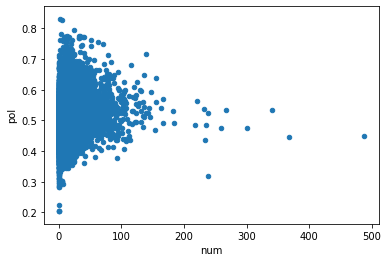

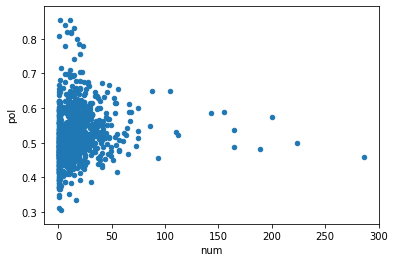

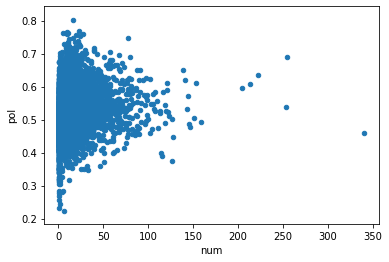

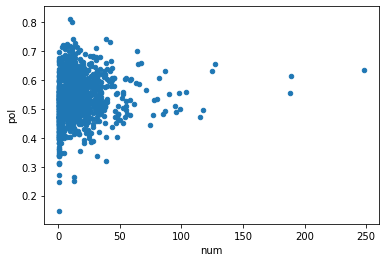

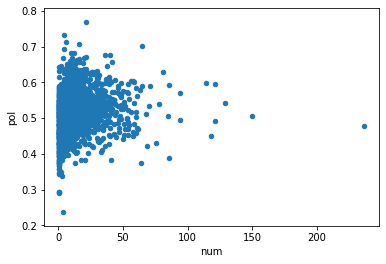

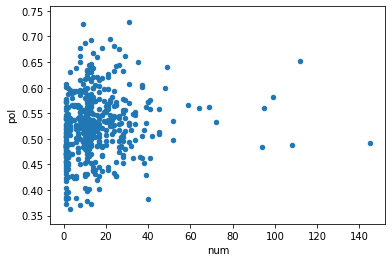

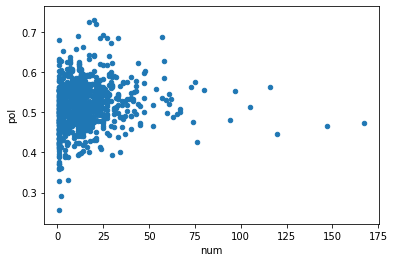

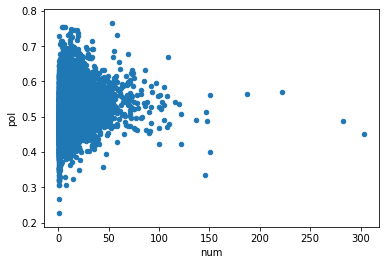

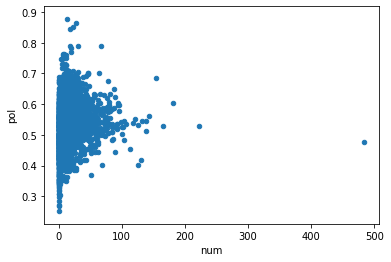

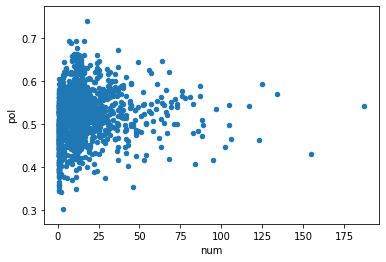

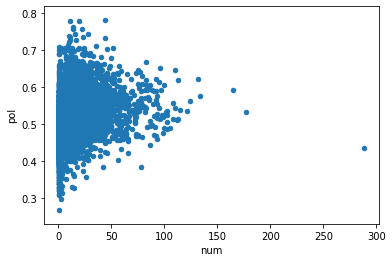

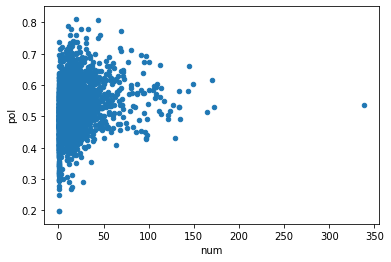

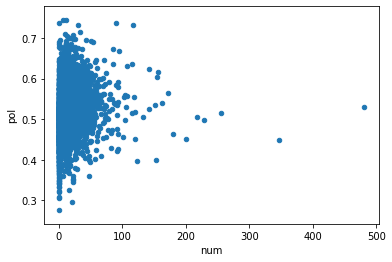

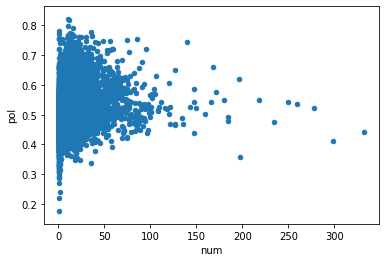

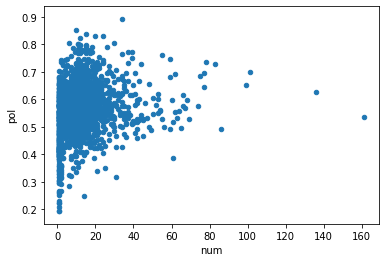

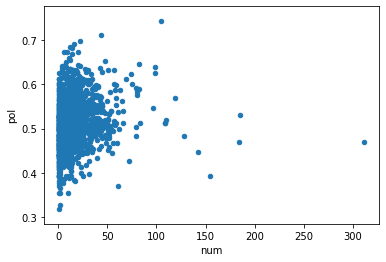

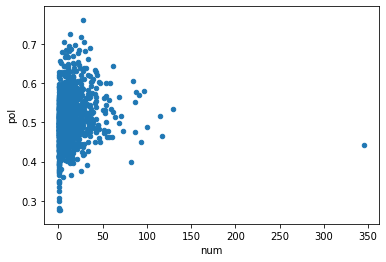

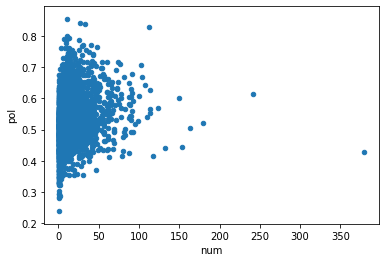

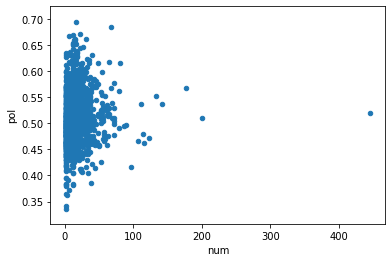

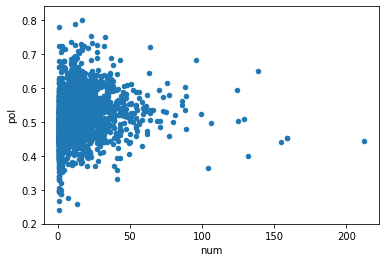

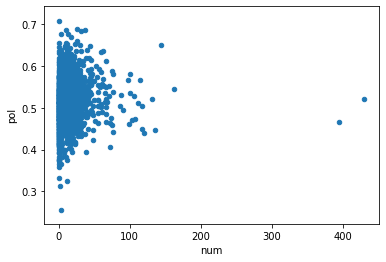

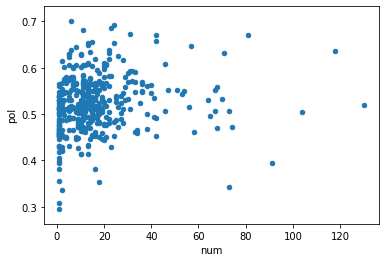

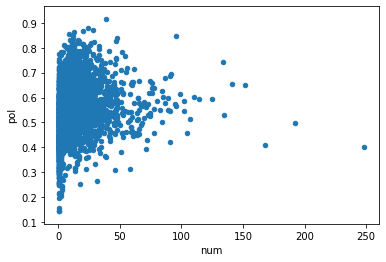

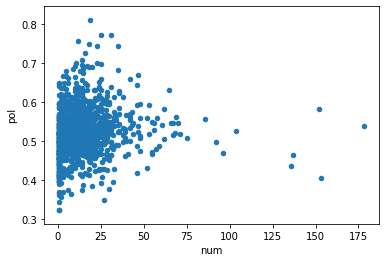

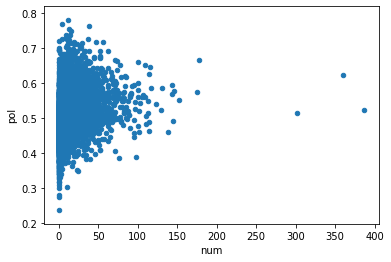

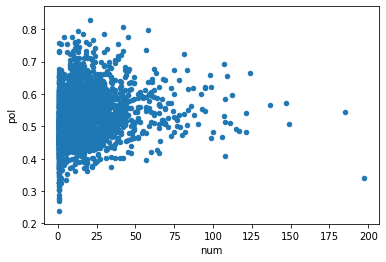

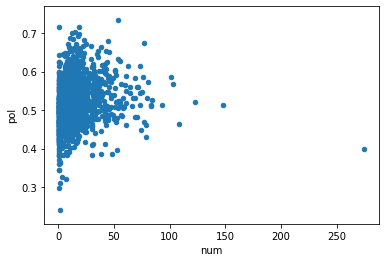

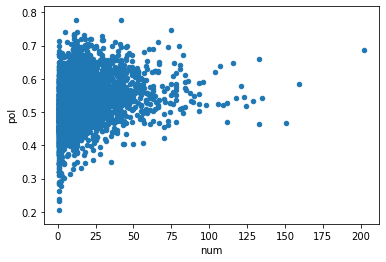

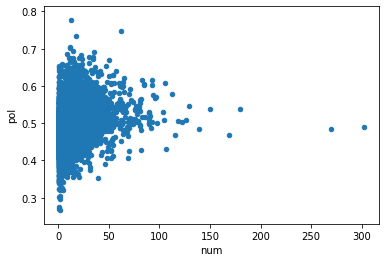

In [59]:
counts.groupby('topic').plot.scatter('num', 'pol')

In [51]:
counts[counts['num'] > 50].sort_values(['pol', 'num'], ascending=[True, False])

,retweeted_status-id_str,full_text,source,pol,num,min_num
2421,1234040432306401280,RT @m_gdula: Dziś Narodowy Dzień Pamięci Żołni...,opp,0.313637,58,-58
35475,1252221903378558977,RT @USAmbPoland: .@FaktyTVN jest częścią rodzi...,opp,0.318715,239,-239
73080,1277917060010557442,RT @BoniekZibi: Prezydent Polski dzisiaj może ...,opp,0.333728,146,-146
30352,1248879817656762368,RT @Bart_Wielinski: Mural na jednej z kamienic...,opp,0.339451,197,-197
20322,1243829201326813186,RT @R_A_Ziemkiewicz: Kosiniak oskarża PO że zd...,gov,0.343685,73,-73
...,...,...,...,...,...,...
83613,1281846036944891904,"RT @ipngovpl: Ginęli od kul, siekier, wideł, n...",gov,0.782359,52,-52
81352,1280901242949115906,RT @sikorskiradek: Jarosław Kaczyński przegrał...,opp,0.789114,67,-67
68153,1275439848933875712,"RT @michalkarnowski: Prezes Wód Polskich: ""MPW...",gov,0.798923,58,-58
73576,1278050759976849409,RT @LewitujacyUmysl: BUM ‼️\n\n14 marca tego r...,opp,0.827274,112,-112


## Replies

In [16]:
cols = ['created_at','full_text','id_str','in_reply_to_status_id_str', 'user-id_str']
PATH_DATA = '/media/piotr/SAMSUNG/data'
target_file = 'replies.csv'
ff = partial(filter_fun, drop_users=drop_users, drop_tweets=drop_tweets)
for src in ['gov','opp']:
    path_data_party = os.path.join(PATH_DATA, src)
    for fname in tqdm([f for f in os.listdir(path_data_party) if '.csv' in f]):
        df = pd.read_csv(os.path.join(path_data_party, fname), index_col=0, dtype=str, usecols=cols)
        df = ff(df)
        df = df.reset_index()
        replies = df.loc[df['in_reply_to_status_id_str'].notna(), :]
        replies.loc[:, 'source'] = src
        del replies['user-id_str']
        if os.path.isfile(target_file):
            replies.to_csv(target_file, header=False, mode='a')
        else:
            replies.to_csv(target_file)

In [64]:
replies = pd.read_csv('replies.csv', index_col = 0, dtype = str)
fmt = r'[A-Z][a-z]{2}\s[A-Z][a-z]{2}\s[0-9]{2}\s[0-9]{2}:[0-9]{2}:[0-9]{2}\s\+[0-9]{4}\s[0-9]{4}'
good = replies['created_at'].str.match(fmt)
good[good.isna()] = False
replies = replies.loc[good,:]
replies['pol'] = replies['id_str'].apply(lambda x: tweets_polarization.get(x))
replies = replies.dropna(subset = ['pol'])
counts = replies.groupby(['in_reply_to_status_id_str']).size().reset_index()
counts = counts[counts[0] > 10]
inds = counts['in_reply_to_status_id_str'].tolist()
replies = replies[replies['in_reply_to_status_id_str'].isin(inds)]
replies.loc[:,'created_at'] = pd.to_datetime(replies.created_at, format='%a %b %d %H:%M:%S +0000 %Y')

In [65]:
replies = replies.sort_values(['in_reply_to_status_id_str', 'source', 'created_at'])
replies['n'] = replies.groupby(['in_reply_to_status_id_str']).cumcount()
replies['n'] += 1

In [69]:
counts = replies.groupby(['in_reply_to_status_id_str', 'source']).size().reset_index()

In [70]:
counts

,in_reply_to_status_id_str,source,0
0,1114455275891765248,gov,11
1,1134701105441574912,gov,9
2,1134701105441574912,opp,2
3,1185161421270720513,gov,10
4,1185161421270720513,opp,3
...,...,...,...
7817,1282425984969564162,gov,10
7818,1282425984969564162,opp,1
7819,1282427793322708994,gov,5
7820,1282427793322708994,opp,16


In [30]:
replies.sort_values('pol', ascending = False)

,created_at,id_str,full_text,in_reply_to_status_id_str,source,n,pol
557,2020-04-09 07:35:47,1248152614619021314,"@bruxa031 Kalafiorowe różyczki(surowe), gorgon...",1248121004888555522,opp,7,1.000000
27729,2020-07-04 09:19:14,1279344006552588288,@JaroslawKurski #RafałNieKłam #RafałNieKłam #...,1279293194430287872,gov,9,0.914578
18132,2020-04-01 14:40:46,1245360461933162496,@EwaKopacz Pani już podziękujemy😡SokzBuraka 😡 ...,1245298583550734336,gov,27,0.904218
11742,2020-07-01 21:34:49,1278441955391868935,@AndrzejDuda #DudaCykor\n#DudaCykor\n#DudaCyko...,1278434232084443136,opp,24,0.892662
11743,2020-07-01 21:33:26,1278441608669691906,@AndrzejDuda #DudaCykor\n#DudaCykor\n#DudaCyko...,1278439925340348418,opp,9,0.892662
...,...,...,...,...,...,...,...
5187,2020-03-18 13:43:07,1240272523691995138,@Leszczyna @Platforma_org @premier @Prezydent ...,1240260528599113728,opp,18,0.187393
17412,2020-03-01 10:24:20,1234061902894051328,@BeataSzydlo Żołnierze Wyklęci - Żołnierze Nie...,1234018936603258880,opp,31,0.162683
741,2020-06-27 14:49:53,1276890500499456000,"@KaziSmolinski Za wiki: ""Arriva Bus Transport ...",1276858920561258496,opp,10,0.154592
15730,2020-03-01 17:45:11,1234172849486782471,"@GiertychRoman I odgłos paszczą Iha,ha,ha,ha,h...",1234048998639624192,gov,49,0.130197


In [61]:
counts = replies.groupby('in_reply_to_status_id_str').size().reset_index()
counts = counts[counts[0] > 5]
inds = counts['in_reply_to_status_id_str'].tolist()
corrs = replies[replies['in_reply_to_status_id_str'].isin(inds)].groupby('in_reply_to_status_id_str').corr().reset_index()

In [62]:
corrs = corrs.loc[corrs['level_1'] == 'n', ("in_reply_to_status_id_str", "pol")]

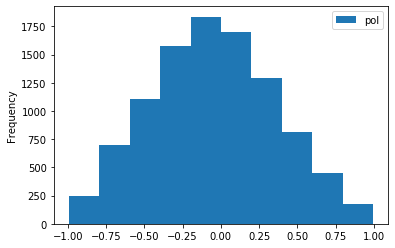

In [63]:
corrs.plot.hist('pol')

## Individual-level correlation:

In [ ]:
user_pol = user_pol.set_index(['date','user-id_str'])
srcs = ['gov','opp']
for src in srcs:
    for dat in tqdm(read_files(os.path.join(PATH_DATA, src), filter_fun=ff, day_from=START, day_to=END, dtype=str)):
        dat = dat.set_index(['date','user-id_str']).join(user_pol, how='left')
        dat['gov_rt'].
        
    